# CS245 Big Data Analytics - Assignment 2
## Deadline: 11:59PM (midnight), November 6, 2024

## Instructions
Each assignment is structured as a Jupyter notebook, offering interactive tutorials that align with our lectures. You will encounter two types of problems: *write-up problems* and *coding problems*.

1. **Write-up Problems:** These problems are primarily theoretical, requiring you to demonstrate your understanding of lecture concepts and to provide mathematical proofs for key theorems. Your answers should include sufficient steps for the mathematical derivations.
2. **Coding Problems:** Here, you will be engaging with practical coding tasks. These may involve completing code segments provided in the notebooks or developing models from scratch.

To ensure clarity and consistency in your submissions, please adhere to the following guidelines:

* For write-up problems, use Markdown bullet points to format text answers. Also, express all mathematical equations using $\LaTeX$ and avoid plain text such as `x0`, `x^1`, or `R x Q` for equations.
* For coding problems, comment on your code thoroughly for readability and ensure your code is executable. Non-runnable code may lead to a loss of **all** points. Coding problems have automated grading, and altering the grading code will result in a deduction of **all** points.
* Your submission should show the entire process of data loading, preprocessing, model implementation, training, and result analysis. This can be achieved through a mix of explanatory text cells, inline comments, intermediate result displays, and experimental visualizations.

### Collaboration and Integrity

* Collaboration is encouraged, but all final submissions must be your own work. Please acknowledge any collaboration or external sources used, including websites, papers, GitHub repositories, and large language models.
* Any suspicious cases of academic misconduct will be reported to The Office of the Dean of Students.

## Before You Start

Useful information about managing environments can be found [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may also quickly review the usage of basic Python and Numpy package, if needed in coding for matrix operations.

In this notebook, you must not delete any code cells in this notebook. If you change any code outside the blocks that you are allowed to edit (between `START/END YOUR CODE HERE`), you need to highlight these changes. You may add some additional cells to help explain your results and observations.

#### GPU Support

Considering the size of the training data, it is strongly suggested to use [Google Colab](https://colab.research.google.com/) or a GPU server for this exercise. If you are using Colab, you can manually switch to a CPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

In [1]:
import torch

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

## Part 1: Node Embedding (55 points)

In this problem, you are going to explore different node embedding methods: LINE, DeepWalk, and Node2Vec.

### Section 1: LINE
In this problem, you will implement the __First-order LINE__: finish contrastive loss, and negative sampling. Train the model, get embedding of karate graph, then visualize your results.

In [2]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
import networkx as nx # new dependency
import numpy as np
from scipy.linalg import sqrtm
from numpy import linalg as LA

In [ ]:
# load dataset and set parameters

G = nx.karate_club_graph()
edges  = np.array(list(G.edges))
degree = dict(G.degree)
true_labels = np.zeros(len(G.nodes))
for i in range(len(true_labels)):
    if G.nodes[i]['club']=='Officer':
        true_labels[i]=1

n_epochs = 100
neg_size = 5
batchrange = 3

#### Problem 1.1: Negative Sampling Loss (15 points)
The goal of negative sampling is to distinguish positive node pairs (existing edges) from random, unconnected node pairs (negative samples).

The loss function for negative sampling is as follows:

$$
\log \sigma (z_v^T z_u) + \sum_{i=1}^{K} E_{v_n \sim P_n(v)} \left[ \log \sigma(-z_{v_n}^T z_u) \right]
$$

where:
- $ z_v $ and $ z_u $ are the embeddings for nodes $v$ and $u$, respectively.
- $ \sigma(x) $ is the sigmoid function.
- $ P_n(v) $ is the noise distribution from which negative samples $ v_n $ are drawn.
- $ K $ is the number of negative samples per positive edge.

1. **Positive Link Loss**: The first term $ \log \sigma (z_v^T z_u) $ maximizes the similarity between nodes $ v $ and $ u $ (positive links in the graph).
2. **Negative Link Loss**: The second term sums over $ K $ negative samples. For each negative sample $ v_n $, we minimize $ \log \sigma(-z_{v_n}^T z_u) $, which ensures that the embeddings of negative samples are far from $ u $.

Your task is to implement the **contrastive loss function** that distinguishes between positive and negative pairs.

Fill in the `loss` function by completing the following steps:

1. **Positive Term**: Compute $ \log \sigma(z_v^T z_u) $.
2. **Negative Term**: For each negative sample $ v_n $, compute $ \log \sigma(-z_{v_n}^T z_u) $.
3. **Sum the Losses**: Return the sum of the positive and negative loss terms.

In [ ]:
class Line(nn.Module):
    def __init__(self, size, embed_dim=128):
        super(Line, self).__init__()

        self.embed_dim = embed_dim
        self.nodes_embeddings = nn.Embedding(size, embed_dim)

        # Initialization
        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(-.5, .5) / embed_dim

    def loss(self, v_i, v_j, negsamples):
        '''
        Compute the LINE contrastive loss with negative sampling.

        Args:
            v_i (Tensor): A batch of target nodes (positive nodes).
            v_j (Tensor): A batch of context nodes (positive neighbors of v_i).
            negsamples (Tensor): A batch of negative samples for v_i.

        TODO:
            1. Compute the positive link loss: log(σ(v_i^T v_j)).
            2. For each negative sample, compute the negative link loss: log(σ(-v_i^T negsamples)).
            3. Return the combined loss.

        Returns:
            loss (Tensor): The total loss (positive + negative).
        '''
        # START YOUR CODE HERE
        ### Step 1: Retrieve embeddings for target and context nodes ###
        # Embeddings for target nodes (v_i), context nodes (v_j), and negative samples using the embedding layer
        v_i_embed = self.nodes_embeddings(v_i)
        v_j_embed = self.nodes_embeddings(v_j)
        neg_embed = self.nodes_embeddings(negsamples)
        ### Step 2: Positive term computation ###
        # Dot product between target and context embeddings using element-wise multiplication and sum
        pos_score = torch.sum(v_i_embed * v_j_embed, dim=1)
        pos_loss = F.logsigmoid(pos_score) # log sigmoid to get log𝜎(𝑧𝑇𝑣𝑧𝑢)


        ### Step 3: Negative term computation ###
        v_i_expand = v_i_embed.unsqueeze(1)
        neg_score =  torch.sum(v_i_expand * neg_embed, dim=2)
        neg_loss = F.logsigmoid(-neg_score)
        neg_loss = torch.sum(neg_loss, dim=1) # Sum over all negative samples


        ### Step 4: Return the total loss ###
        total_loss = -(pos_loss + neg_loss).mean()


        # END YOUR CODE HERE
        return total_loss

#### Problem 1.2: Negative Sampling in Batch Generation (15 points)
Your task is to complete the section in the `makeData` function that generates negative samples for each edge. The negative samples should be selected based on the probability distribution $ d^{3/4} $, where $ d $ is the degree of the node.

Note that
1. **Probability Distribution**: Negative samples should be drawn from a probability distribution where each node is sampled with probability proportional to its degree raised to the power of $ 3/4 $.
2. **Sampling**: Use the probability distribution to randomly sample negative nodes for each positive edge. Ensure the sampled negative nodes are **not** connected to the positive nodes.

In [ ]:
#     generating batches of data.

def makeData(samplededges, negsamplesize, degree):
    """
    Generates batches of positive and negative samples for LINE.

    Args:
        samplededges (list): A list of edges (positive samples).
        negsamplesize (int): The number of negative samples to generate per edge.
        degree (dict): A dictionary with node degrees {node: degree}.

    Yields:
        list: A batch containing the source node, target node, and negative samples.
    """

    sampledNodes = set()  # A set of nodes involved in the edges
    nodesProb = []        # Probability distribution for sampling negative nodes
    sumofDegree = 0       # Sum of the degrees raised to 3/4

    # Step 1: Collect nodes from edges and calculate probability based on degree
    for e in samplededges:
        sampledNodes.add(e[0])
        sampledNodes.add(e[1])

    sampledNodes = list(sampledNodes)

    # Calculate node sampling probability based on degree^{3/4}
    nodesProb = [pow(degree[v], 3/4) for v in sampledNodes]
    sumofDegree = sum(nodesProb)

    # Normalize the probabilities
    nodesProb = [x / sumofDegree for x in nodesProb]

    # Step 2: Generate batches of data
    for e in samplededges:
        sourcenode, targetnode = e[0], e[1]
        negnodes = []
        negsamples = 0

        while negsamples < negsamplesize:
            # START YOUR CODE HERE
            # Step 2.1: Sample a negative node based on the nodesProb distribution
            sampled_negnode = np.random.choice(sampledNodes, p=nodesProb)

            # Step 2.2: Check if the sampled node is not a positive node (avoid connections to source/target nodes)
            if (sampled_negnode != sourcenode and
                sampled_negnode != targetnode and
                sampled_negnode not in negnodes):
              negnodes.append(sampled_negnode)
              negsamples += 1

        # END YOUR CODE HERE
        # Yield the batch: [sourcenode, targetnode, negative_samples]
        yield [sourcenode, targetnode] + negnodes

In [ ]:
# training

line = Line(len(G), embed_dim=100)
opt = optim.Adam(line.parameters())
for epoch in range(n_epochs):
    for b in trange(batchrange):
        opt.zero_grad()
        edge_idx = np.random.choice(len(edges), 10)
        samplededges = edges[edge_idx]

        batch = list(makeData(samplededges, neg_size, degree))
        batch = torch.LongTensor(batch)

        # based on the generated batch, train LINE via minimizing the loss.
        v_i = batch[:,0]
        v_j = batch[:,1]
        negsamples =  batch[:,2:]
        loss = line.loss(v_i, v_j, negsamples)
        loss.backward()
        opt.step()

100%|██████████| 3/3 [00:00<00:00, 210.81it/s]


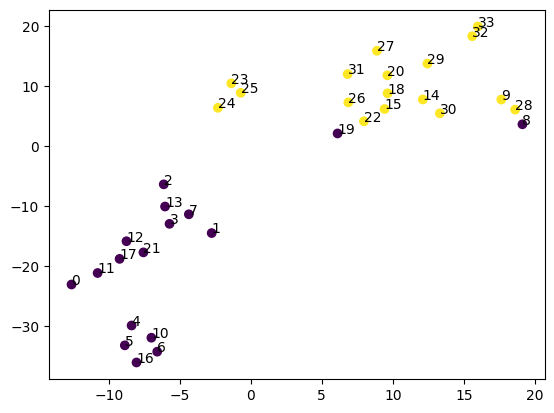

In [ ]:
# TSNE visualization, with node id on

emb  = line.nodes_embeddings.weight.data.numpy()
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10, random_state=1).fit_transform(emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=true_labels)
for i in range(len(tsne_emb)):
    plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()

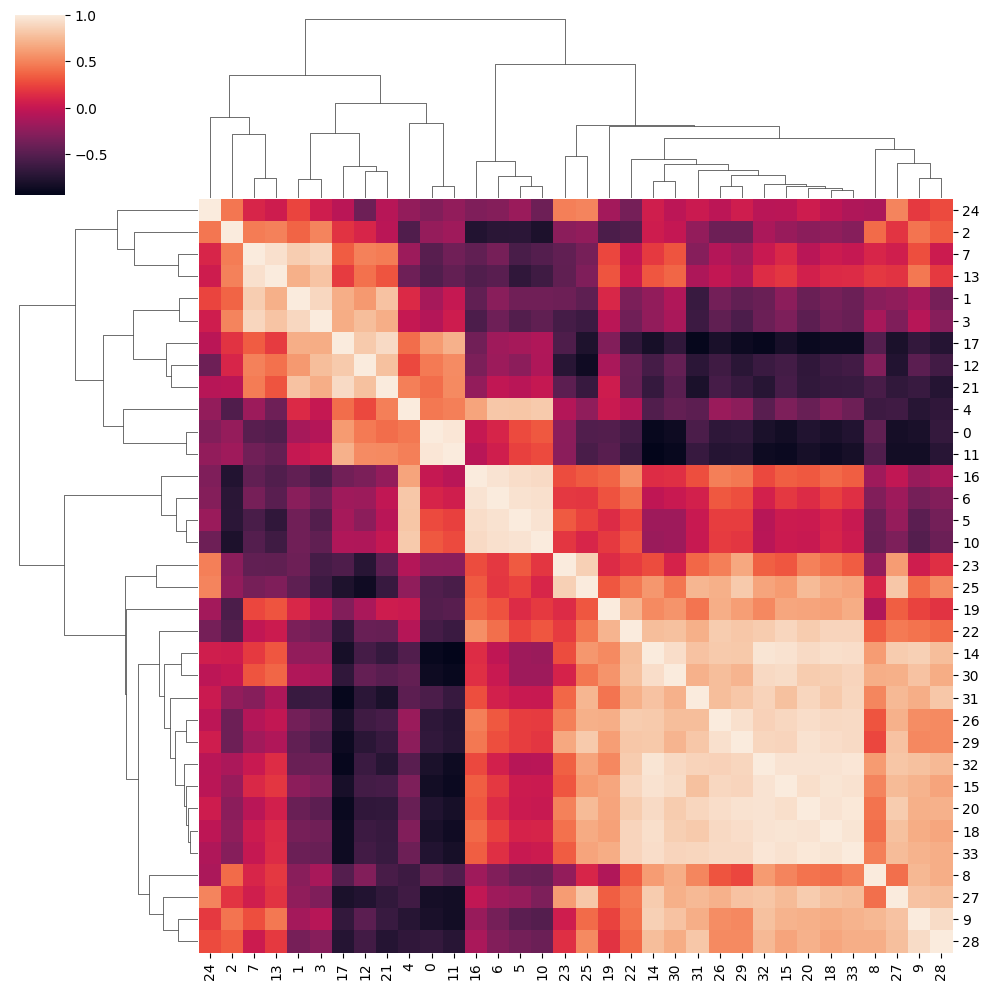

In [ ]:
# heatmap visualization, check cosine similarities between all pair of nodes
res = cosine_similarity(emb)

sb.clustermap(res)
plt.show()

### Section 2: Random Walks in DeepWalk and Node2Vec
In this problem, you will complete parts of the random walk generation process for two node embedding techniques: **DeepWalk** and **Node2Vec**. Both methods rely on walking through the graph to capture structural information, but Node2Vec introduces biased random walks that favor exploring either breadth-first or depth-first neighborhoods.

Your task is to:
1. Implement a **uniform random walk** for DeepWalk.
2. Implement a **biased random walk** for Node2Vec.

#### Problem 1.3: Uniform Random Walk for DeepWalk (10 points)

Complete the `deepwalk_random_walk` function to perform a simple random walk starting from a node. The next node is chosen uniformly from the neighbors of the current node.

In [ ]:
import random
import networkx as nx

def deepwalk_random_walk(graph, start_node, walk_length):
    """
    Simulates a random walk starting from a given node.

    Args:
        graph (networkx.Graph): The input graph.
        start_node (int): The node to start the walk from.
        walk_length (int): Number of steps in the walk.

    Returns:
        list: A list of node IDs representing the walk.
    """
    walk = [start_node]

    for _ in range(walk_length - 1):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))

        if len(neighbors) > 0:
            # TODO: Choose the next node uniformly from neighbors
            # START YOUR CODE HERE
            next_node = random.choice(neighbors) # Selects the next node
            walk.append(next_node)
            # END YOUR CODE HERE
        else:
            break  # If a node has no neighbors, stop the walk

    return walk

In [ ]:
# Test the DeepWalk random walk
G = nx.karate_club_graph()  # Example graph
print(deepwalk_random_walk(G, start_node=0, walk_length=5))

[0, 4, 10, 0, 19]


#### Problem 1.4: Biased Random Walk for Node2Vec (15 points)

Now, modify the walk process to implement a **biased random walk** for Node2Vec. Node2Vec introduces two hyperparameters:
- `p` (return parameter): Likelihood of revisiting the previous node (encouraging depth-first search).
- `q` (in-out parameter): Likelihood of exploring further nodes (encouraging breadth-first search).

Your task is to implement the `node2vec_biased_walk` function that biases the walk based on the distance from the previous node. You are given the previous node as an input.

In [ ]:
def node2vec_biased_walk(graph, start_node, walk_length, p, q):
    """
    Simulates a biased random walk as described in Node2Vec.

    Args:
        graph (networkx.Graph): The input graph.
        start_node (int): The node to start the walk from.
        walk_length (int): Number of steps in the walk.
        p (float): Return hyperparameter.
        q (float): In-out hyperparameter.

    Returns:
        list: A list of node IDs representing the walk.
    """
    walk = [start_node]

    for _ in range(walk_length - 1):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))

        if len(neighbors) > 0:
            if len(walk) == 1:  # No previous node
                # TODO: Choose the next node uniformly from neighbors
                # START YOUR CODE HERE
                next_node = random.choice(neighbors) # Selects the next node
                # END YOUR CODE HERE
            else:
                prev_node = walk[-2]
                probabilities = []

                # TODO: Asign correct probability based on the algorithm
                for neighbor in neighbors:
                    curr_prob = None
                    # START YOUR CODE HERE
                    if neighbor == prev_node:  # Return to the previous node
                        curr_prob = 1/p
                    elif graph.has_edge(prev_node, neighbor):  # Neighbor of previous node
                        curr_prob = 1
                    else:  # Further nodes
                        curr_prob = 1/q
                    # END YOUR CODE HERE
                    probabilities.append(curr_prob)

                # Normalize probabilities
                total = sum(probabilities)
                probabilities = [prob / total for prob in probabilities]

                # TODO: Select next node based on biased probabilities
                # START YOUR CODE HERE
                next_node = random.choices(neighbors, weights=probabilities, k=1)[0]
                # END YOUR CODE HERE

            walk.append(next_node)
        else:
            break  # If a node has no neighbors, stop the walk

    return walk

In [ ]:
# Test the Node2Vec biased walk
print(node2vec_biased_walk(G, start_node=0, walk_length=5, p=1.0, q=2.0))

[0, 12, 3, 7, 2]


## Part 2: Knowledge Graph Embedding (55 points)

In this probelm, we implement the simple KG embedding algorithm of TransE and RotateE. We use the ```wn18rr``` dataset.

### Problem 2.1: Data Loading (10 pts)
This section contains the boilerplate code for data loading and dataset construction (__DO NOT MODIFY THIS PART__) unless in the TODO section

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, triples, nentity, nrelation, negative_sample_size, mode):
        self.len = len(triples)
        self.triples = triples
        self.triple_set = set(triples)
        self.nentity = nentity
        self.nrelation = nrelation
        self.negative_sample_size = negative_sample_size
        self.mode = mode
        self.count = self.count_frequency(triples)
        self.true_head, self.true_tail = self.get_true_head_and_tail(self.triples)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        positive_sample = self.triples[idx]

        head, relation, tail = positive_sample

        subsampling_weight = self.count[(head, relation)] + self.count[(tail, -relation-1)]
        subsampling_weight = torch.sqrt(1 / torch.Tensor([subsampling_weight]))

        negative_sample_list = []
        negative_sample_size = 0

        while negative_sample_size < self.negative_sample_size:
            negative_sample = np.random.randint(self.nentity, size=self.negative_sample_size*2)
            if self.mode == 'head-batch':
                mask = np.in1d(
                    negative_sample,
                    self.true_head[(relation, tail)],
                    assume_unique=True,
                    invert=True
                )
            elif self.mode == 'tail-batch':
                mask = np.in1d(
                    negative_sample,
                    self.true_tail[(head, relation)],
                    assume_unique=True,
                    invert=True
                )
            else:
                raise ValueError('Training batch mode %s not supported' % self.mode)
            negative_sample = negative_sample[mask]
            negative_sample_list.append(negative_sample)
            negative_sample_size += negative_sample.size

        negative_sample = np.concatenate(negative_sample_list)[:self.negative_sample_size]

        negative_sample = torch.LongTensor(negative_sample)

        positive_sample = torch.LongTensor(positive_sample)

        return positive_sample, negative_sample, subsampling_weight, self.mode

    @staticmethod
    def collate_fn(data):
        positive_sample = torch.stack([_[0] for _ in data], dim=0)
        negative_sample = torch.stack([_[1] for _ in data], dim=0)
        subsample_weight = torch.cat([_[2] for _ in data], dim=0)
        mode = data[0][3]
        return positive_sample, negative_sample, subsample_weight, mode

    @staticmethod
    def count_frequency(triples, start=4):
        '''
        Get frequency of a partial triple like (head, relation) or (relation, tail)
        The frequency will be used for subsampling like word2vec
        '''
        count = {}
        for head, relation, tail in triples:
            if (head, relation) not in count:
                count[(head, relation)] = start
            else:
                count[(head, relation)] += 1

            if (tail, -relation-1) not in count:
                count[(tail, -relation-1)] = start
            else:
                count[(tail, -relation-1)] += 1
        return count

    @staticmethod
    def get_true_head_and_tail(triples):
        '''
        Build a dictionary of true triples that will
        be used to filter these true triples for negative sampling
        '''

        true_head = {}
        true_tail = {}

        for head, relation, tail in triples:
            if (head, relation) not in true_tail:
                true_tail[(head, relation)] = []
            true_tail[(head, relation)].append(tail)
            if (relation, tail) not in true_head:
                true_head[(relation, tail)] = []
            true_head[(relation, tail)].append(head)

        for relation, tail in true_head:
            true_head[(relation, tail)] = np.array(list(set(true_head[(relation, tail)])))
        for head, relation in true_tail:
            true_tail[(head, relation)] = np.array(list(set(true_tail[(head, relation)])))

        return true_head, true_tail


class TestDataset(Dataset):
    def __init__(self, triples, all_true_triples, nentity, nrelation, mode):
        self.len = len(triples)
        self.triple_set = set(all_true_triples)
        self.triples = triples
        self.nentity = nentity
        self.nrelation = nrelation
        self.mode = mode

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        head, relation, tail = self.triples[idx]

        if self.mode == 'head-batch':
            tmp = [(0, rand_head) if (rand_head, relation, tail) not in self.triple_set
                   else (-1, head) for rand_head in range(self.nentity)]
            tmp[head] = (0, head)
        elif self.mode == 'tail-batch':
            tmp = [(0, rand_tail) if (head, relation, rand_tail) not in self.triple_set
                   else (-1, tail) for rand_tail in range(self.nentity)]
            tmp[tail] = (0, tail)
        else:
            raise ValueError('negative batch mode %s not supported' % self.mode)

        tmp = torch.LongTensor(tmp)
        filter_bias = tmp[:, 0].float()
        negative_sample = tmp[:, 1]

        positive_sample = torch.LongTensor((head, relation, tail))

        return positive_sample, negative_sample, filter_bias, self.mode

    @staticmethod
    def collate_fn(data):
        positive_sample = torch.stack([_[0] for _ in data], dim=0)
        negative_sample = torch.stack([_[1] for _ in data], dim=0)
        filter_bias = torch.stack([_[2] for _ in data], dim=0)
        mode = data[0][3]
        return positive_sample, negative_sample, filter_bias, mode

class BidirectionalOneShotIterator(object):
    def __init__(self, dataloader_head, dataloader_tail):
        self.iterator_head = self.one_shot_iterator(dataloader_head)
        self.iterator_tail = self.one_shot_iterator(dataloader_tail)
        self.step = 0

    def __next__(self):
        self.step += 1
        if self.step % 2 == 0:
            data = next(self.iterator_head)
        else:
            data = next(self.iterator_tail)
        return data

    @staticmethod
    def one_shot_iterator(dataloader):
        while True:
            for data in dataloader:
                yield data

In [ ]:
def read_triple(file_path, entity2id, relation2id):
    '''
    Read triples and map them into ids.
    '''
    triples = []
    with open(file_path) as fin:
        for line in fin:
            h, r, t = line.strip().split('\t')
            triples.append((entity2id[h], relation2id[r], entity2id[t]))
    return triples

In [ ]:
# Mount Googld Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
data_path = "/content/drive/MyDrive/Master of Engineering/hw2 (1)/wn18rr"
with open(os.path.join(data_path, 'entities.dict')) as fin:
        entity2id = dict()
        for line in fin:
            eid, entity = line.strip().split('\t')
            entity2id[entity] = int(eid)

with open(os.path.join(data_path, 'relations.dict')) as fin:
    relation2id = dict()
    for line in fin:
        rid, relation = line.strip().split('\t')
        relation2id[relation] = int(rid)

nentity = len(entity2id)
nrelation = len(relation2id)
print(f"nentity = {nentity}, nrelation={nrelation}")

nentity = 40943, nrelation=11


In [ ]:
train_triples = read_triple(os.path.join(data_path, 'train.txt'), entity2id, relation2id)
valid_triples = read_triple(os.path.join(data_path, 'valid.txt'), entity2id, relation2id)
test_triples = read_triple(os.path.join(data_path, 'test.txt'), entity2id, relation2id)
print(f"n_training triples = {len(train_triples)}")
print(f"n_validation triples = {len(valid_triples)}")
print(f"n_test triples = {len(test_triples)}")

n_training triples = 86835
n_validation triples = 3034
n_test triples = 3134


In [ ]:
all_true_triples = train_triples + valid_triples + test_triples

In [ ]:
# TODO: create two data loaders, one for the head entities and one for the tail entities, using the DataLoader class above.
negative_sample_size = 2
batch_size = 200

# SATRT YOUR CODE HERE
# Create datasets for head-batch and tail-batch modes
train_dataset_head = TrainDataset(triples=train_triples, nentity=nentity, nrelation=nrelation, negative_sample_size=negative_sample_size, mode='head-batch')
train_dataset_tail = TrainDataset(triples=train_triples, nentity=nentity, nrelation=nrelation, negative_sample_size=negative_sample_size, mode='tail-batch')
train_dataloader_head = DataLoader(train_dataset_head, batch_size=batch_size, shuffle=True, collate_fn=TrainDataset.collate_fn)
train_dataloader_tail = DataLoader(train_dataset_tail, batch_size=batch_size, shuffle=True, collate_fn=TrainDataset.collate_fn)
# train_dataloader_head = ...
# train_dataloader_tail = ...
# END YOUR CODE HERE

In [ ]:
train_iterator = BidirectionalOneShotIterator(train_dataloader_head, train_dataloader_tail)

### Problem 2.2: Model Implementation (25 points)

In this problem, You are provided with the **KGEModel** class that initializes the embeddings for entities and relations. Your task is to:
1. **Complete the `TransE` function** by implementing the scoring mechanism for TransE.
2. **Understand the `RotatE` function** and observe how rotations are used to compute scores for triples.

#### Problem 2.2.1: Completing the TransE Score Function (10 points)
1. **Head-batch Mode**: In this mode, we compute the score for multiple candidate head entities and a fixed relation and tail entity. The formula is:  
   $$
   \text{score} = h + (r - t)
   $$
2. **Tail-batch Mode**: In this mode, we compute the score for multiple candidate tail entities and a fixed head and relation. The formula is:  
   $$
   \text{score} = (h + r) - t
   $$
3. **Return the final score**: Subtract the L1 norm of the computed score from the margin $ \gamma $.

#### Problem 2.2.2: Completing the RotatE Score Function (15 points)

In **RotatE**, entities are represented as complex numbers, split into real and imaginary parts. Relations are modeled as rotations in the complex plane. The goal is for the head entity, when rotated by the relation, to match the tail entity. The scoring function is computed using the following process:

1. **Entity Embeddings**: Split the entity embeddings into real and imaginary parts.
2. **Relation Embedding**: The relation embedding is transformed into a phase angle that is used to compute the rotation (via sine and cosine).
3. **Score Computation**: Compute the rotation and calculate the difference between the rotated head and the tail.

The score is computed as:

$$
\text{score}(h, r, t) = \gamma - \| [\text{Re}(h) \circ \text{Re}(r) - \text{Im}(h) \circ \text{Im}(r), \text{Re}(h) \circ \text{Im}(r) + \text{Im}(h) \circ \text{Re}(r)] - [\text{Re}(t), \text{Im}(t)] \|_2
$$

Where:
- $ h $, $ r $, and $ t $ are split into real (Re) and imaginary (Im) parts.
- $ \circ $ denotes element-wise multiplication.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class KGEModel(nn.Module):
    def __init__(self, model_name, nentity, nrelation, hidden_dim, gamma,
                 double_entity_embedding=False, double_relation_embedding=False):
        super(KGEModel, self).__init__()
        self.model_name = model_name
        self.nentity = nentity
        self.nrelation = nrelation
        self.hidden_dim = hidden_dim
        self.epsilon = 2.0


        self.gamma = nn.Parameter(
            torch.Tensor([gamma]),
            requires_grad=False
        )

        self.embedding_range = nn.Parameter(
            torch.Tensor([(self.gamma.item() + self.epsilon) / hidden_dim]),
            requires_grad=False
        )

        self.entity_dim = hidden_dim*2 if double_entity_embedding else hidden_dim
        self.relation_dim = hidden_dim*2 if double_relation_embedding else hidden_dim

        # shallow embedding of size nentity by entity_dim
        self.entity_embedding = nn.Parameter(torch.zeros(nentity, self.entity_dim))
        nn.init.uniform_(
            tensor=self.entity_embedding,
            a=-self.embedding_range.item(),
            b=self.embedding_range.item()
        )

        self.relation_embedding = nn.Parameter(torch.zeros(nrelation, self.relation_dim))
        nn.init.uniform_(
            tensor=self.relation_embedding,
            a=-self.embedding_range.item(),
            b=self.embedding_range.item()
        )

    def forward(self, sample, mode='single'):
        '''
        Forward function that calculate the score of a batch of triples.
        In the 'single' mode, sample is a batch of triple.
        In the 'head-batch' or 'tail-batch' mode, sample consists two part.
        The first part is usually the positive sample.
        And the second part is the entities in the negative samples.
        Because negative samples and positive samples usually share two elements
        in their triple ((head, relation) or (relation, tail)).
        '''

        if mode == 'single':
            batch_size, negative_sample_size = sample.size(0), 1

            head = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=sample[:,0]
            ).unsqueeze(1)

            relation = torch.index_select(
                self.relation_embedding,
                dim=0,
                index=sample[:,1]
            ).unsqueeze(1)

            tail = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=sample[:,2]
            ).unsqueeze(1)

        elif mode == 'head-batch':
            tail_part, head_part = sample
            batch_size, negative_sample_size = head_part.size(0), head_part.size(1)

            head = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=head_part.view(-1)
            ).view(batch_size, negative_sample_size, -1)

            relation = torch.index_select(
                self.relation_embedding,
                dim=0,
                index=tail_part[:, 1]
            ).unsqueeze(1)

            tail = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=tail_part[:, 2]
            ).unsqueeze(1)

        elif mode == 'tail-batch':
            head_part, tail_part = sample
            batch_size, negative_sample_size = tail_part.size(0), tail_part.size(1)

            head = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=head_part[:, 0]
            ).unsqueeze(1)

            relation = torch.index_select(
                self.relation_embedding,
                dim=0,
                index=head_part[:, 1]
            ).unsqueeze(1)

            tail = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=tail_part.view(-1)
            ).view(batch_size, negative_sample_size, -1)

        else:
            raise ValueError('mode %s not supported' % mode)

        model_func = {
            'TransE': self.TransE,
            'RotatE': self.RotatE,
        }

        if self.model_name in model_func:
            score = model_func[self.model_name](head, relation, tail, mode)
        else:
            raise ValueError('model %s not supported' % self.model_name)

        return score


    def TransE(self, head, relation, tail, mode):
        """
        TODO: Implement the TransE scoring function.

        Args:
            head (Tensor): Embeddings for the head entities.
            relation (Tensor): Embeddings for the relations.
            tail (Tensor): Embeddings for the tail entities.
            mode (str): Mode indicating whether we are computing for head-batch or tail-batch.

        Steps:
            1. Compute the score depending on the mode
            2. Compute the L1 norm of the resulting vector.
            3. Subtract the norm from the margin `gamma` to get the final score.

        Returns:
            Tensor: The computed scores.
        """
        # START YOUR CODE HERE
        # Step 1: Compute the score depending on the mode
        # if mode == 'head-batch':
        #     ...
        if mode == 'head-batch':
            score = head + (relation - tail)
        else:
            score = (head + relation) - tail
        # else:
        #     raise ValueError ('mode is not supported)

        # Step 2: Compute the L1 norm of the score (use torch.norm with p=1)
        # score = ...
        score = torch.norm(score, p=1, dim=2)

        # Step 3: Subtract the norm from the margin (gamma)
        # score = ...
        score = self.gamma - score

        # END YOUR CODE HERE
        return score


    def RotatE(self, head, relation, tail, mode):
        """
        TODO: Implement the RotatE scoring function.

        Args:
            head (Tensor): Embeddings for the head entities.
            relation (Tensor): Embeddings for the relations.
            tail (Tensor): Embeddings for the tail entities.
            mode (str): Mode indicating whether we are computing for head-batch or tail-batch.

        Steps:
            1. Split the embeddings of head and tail into real and imaginary parts.
            2. Convert the relation embedding into a phase angle and compute the rotation (cosine and sine).
            3. Apply the rotation to either the head or the tail based on the mode.
            4. Compute the L2 norm of the resulting vector.
            5. Subtract the norm from the margin `gamma` to get the final score.

        Returns:
            Tensor: The computed scores.
        """
        pi = 3.14159265358979323846

        # Step 1: Split head and tail into real and imaginary parts
        re_head, im_head = torch.chunk(head, 2, dim=2)
        re_tail, im_tail = torch.chunk(tail, 2, dim=2)

        # START YOUR CODE HERE
        # Step 2: Compute the phase of the relation
        # phase_relation = ...
        # re_relation = ...
        # im_relation = ...
        phase_relation = relation / (self.embedding_range.item() / pi)
        re_relation = torch.cos(phase_relation)
        im_relation = torch.sin(phase_relation)

        # Step 3: Apply the rotation based on the mode
        # if mode == 'head-batch':
        #     ...
        # else:
        #     ...
        if mode == 'head-batch':
            re_score = re_tail * re_relation + im_tail * im_relation
            im_score = im_tail * re_relation - re_tail * im_relation
            re_score = re_score - re_head
            im_score = im_score - im_head
        else:
            re_score = re_head * re_relation - im_head * im_relation
            im_score = re_head * im_relation + im_head * re_relation
            re_score = re_score - re_tail
            im_score = im_score - im_tail

        # Step 4: Compute the L2 norm of the score
        # score = ...
        score = torch.stack([re_score, im_score], dim=0)
        score = score.norm(dim=0)
        score = score.norm(dim=-1)

        # Step 5: Subtract the norm from the margin (gamma)
        # score = ...
        score = self.gamma - score

        # END YOUR CODE HERE
        return score


### Problem 2.3: Training, Validation, Test (20 points)
In this problem, you are to complete the training, valiation, and testing step. Complete the data loader, initialize the model, and get results.


Note that we use MRR as the evaluation metric:

The **Mean Reciprocal Rank (MRR)** is the usual choice to evaluate the result of knowledge graph embedding. It has the formula:
$$
MRR + \frac{1}{|Q|}\sum_{i=1}^{|Q|} \frac{1}{rank_i}
$$
where $Q$ is the set of queries, and rank is defined as the order of similarity, defined by the score in the KG embedding loss. Larger score corresponds to higher rank.

In [ ]:
cuda = True # if you are on colab

In [ ]:
def train_step(model, optimizer, train_iterator):
        model.train()
        optimizer.zero_grad()
        positive_sample, negative_sample, _, mode = next(train_iterator)
        if cuda:
            positive_sample = positive_sample.cuda()
            negative_sample = negative_sample.cuda()
        # loss computation
        negative_score = model((positive_sample, negative_sample), mode=mode)
        negative_score = F.logsigmoid(-negative_score).mean(dim = 1)
        positive_score = model(positive_sample)
        positive_score = F.logsigmoid(positive_score).squeeze(dim = 1)
        positive_sample_loss = - positive_score.mean()
        negative_sample_loss = - negative_score.mean()
        loss = (positive_sample_loss + negative_sample_loss)/2

        loss.backward()
        optimizer.step()

        log = {
            'positive_sample_loss': positive_sample_loss.item(),
            'negative_sample_loss': negative_sample_loss.item(),
            'loss': loss.item()
        }

        return log

#### Problem 2.3.1: Data Loading (5 points)
Similar to training data loader, implement your test data loader here.

In [ ]:
def test_step(model, test_triples, all_true_triples):
    model.eval()

    # TODO: create two test loaders one for head one for tail.
    # You can choose your own batch_size
    batch_size = 100

    # SATRT YOUR CODE HERE
    # train_dataloader_head = ...
    # train_dataloader_tail = ...
    # Create test datasets for head and tail
    test_dataset_head = TestDataset(test_triples, all_true_triples, nentity, nrelation, 'head-batch')

    test_dataset_tail = TestDataset(test_triples, all_true_triples, nentity, nrelation, 'tail-batch')

    test_dataloader_head = DataLoader(test_dataset_head, batch_size=batch_size, collate_fn=TestDataset.collate_fn, shuffle=False)

    test_dataloader_tail = DataLoader(test_dataset_tail, batch_size=batch_size, collate_fn=TestDataset.collate_fn, shuffle=False)
    # END YOUR CODE HERE

    test_dataset_list = [test_dataloader_head, test_dataloader_tail]
    logs = []
    step = 0
    test_log_steps = 10
    total_steps = sum([len(dataset) for dataset in test_dataset_list])
    with torch.no_grad():
        for test_dataset in test_dataset_list:
            for positive_sample, negative_sample, filter_bias, mode in test_dataset:
                if cuda:
                    positive_sample = positive_sample.cuda()
                    negative_sample = negative_sample.cuda()
                    filter_bias = filter_bias.cuda()

                batch_size = positive_sample.size(0)

                score = model((positive_sample, negative_sample), mode)
                score += filter_bias
                argsort = torch.argsort(score, dim = 1, descending=True)
                if mode == 'head-batch':
                    positive_arg = positive_sample[:, 0]
                elif mode == 'tail-batch':
                    positive_arg = positive_sample[:, 2]
                else:
                    raise ValueError('mode %s not supported' % mode)
                for i in range(batch_size):
                    ranking = (argsort[i, :] == positive_arg[i]).nonzero()
                    assert ranking.size(0) == 1

                    ranking = 1 + ranking.item()
                    logs.append({
                        'MRR': 1.0/ranking,
                        'MR': float(ranking),
                        'HITS@1': 1.0 if ranking <= 1 else 0.0,
                        'HITS@3': 1.0 if ranking <= 3 else 0.0,
                        'HITS@10': 1.0 if ranking <= 10 else 0.0,
                    })
                if step % test_log_steps == 0:
                    print('Evaluating the model... (%d/%d)' % (step, total_steps))

                step += 1
    metrics = {}
    for metric in logs[0].keys():
        metrics[metric] = sum([log[metric] for log in logs])/len(logs)

    return metrics

#### Problem 2.3.2: Model Initializing (5 points)
You will first handpick hyperparameters for optimization, together with the optimizer. Then initialize the two models: one for TransE, and one for RotateE.

In [ ]:
# START YOUR CODE HERE
# max_steps = ...
# hidden_dim = ...
# gamma = ...
# learning_rate = ...
max_steps = 1000 # Preferably <2000
hidden_dim = 100 # Affects training time significantly
gamma = 1.1
learning_rate = 0.001
# END YOUR CODE HERE

# TransE
# model_TransE = ... # move to cuda if using gpu
model_TransE = KGEModel(
    model_name='TransE',
    nentity=nentity,
    nrelation=nrelation,
    hidden_dim=hidden_dim,
    gamma=gamma,
    double_entity_embedding=False,  # TransE has single embedding
    double_relation_embedding=False
).cuda()

optimizer_TransE = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model_TransE.parameters()),
            lr=learning_rate
        )

# RotatE
# model_RotatE = ... # move to cuda if using gpu
model_RotatE = KGEModel(
    model_name='RotatE',
    nentity=nentity,
    nrelation=nrelation,
    hidden_dim=hidden_dim,
    gamma=gamma,
    double_entity_embedding=True,  # RotatE wants double embedding for complex numbers
    double_relation_embedding=False
).cuda()

optimizer_RotatE = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model_RotatE.parameters()),
            lr=learning_rate
        )

#### Problem 2.3.3: Model Training (5 points)
Train the two models separately.

In [ ]:
def train_model(max_steps, kge_model, optimizer):
    training_logs = []
    for step in range(0, max_steps):
        log = train_step(kge_model, optimizer, train_iterator)
        training_logs.append(log)
        if step % 200 == 0:
            metrics = test_step(kge_model, valid_triples, all_true_triples)
            print(f"step = {step}")
            print(metrics)
    return kge_model

In [ ]:
print('training TransE')
# START YOOU CODE HERE
max_steps = 1000
trained_TransE = train_model(max_steps, model_TransE, optimizer_TransE)
# Took about 10 minutes
# END YOU CODE HERE

training TransE
Evaluating the model... (0/62)
Evaluating the model... (10/62)
Evaluating the model... (20/62)
Evaluating the model... (30/62)
Evaluating the model... (40/62)
Evaluating the model... (50/62)
Evaluating the model... (60/62)
step = 0
{'MRR': 0.10153790084043111, 'MR': 9794.307514831906, 'HITS@1': 0.003131179960448253, 'HITS@3': 0.16875411997363216, 'HITS@10': 0.28394858272907053}
Evaluating the model... (0/62)
Evaluating the model... (10/62)
Evaluating the model... (20/62)
Evaluating the model... (30/62)
Evaluating the model... (40/62)
Evaluating the model... (50/62)
Evaluating the model... (60/62)
step = 200
{'MRR': 0.10784220470207577, 'MR': 8962.691166776533, 'HITS@1': 0.004119973632168754, 'HITS@3': 0.17155570204350692, 'HITS@10': 0.3103164139749506}
Evaluating the model... (0/62)
Evaluating the model... (10/62)
Evaluating the model... (20/62)
Evaluating the model... (30/62)
Evaluating the model... (40/62)
Evaluating the model... (50/62)
Evaluating the model... (60/62

In [ ]:
print('training RotatE')
# START YOOU CODE HERE
max_steps = 1000
trained_RotatE = train_model(max_steps, model_RotatE, optimizer_RotatE)
# Took about 10 minutes
# Should max_steps be higher? Maybe 2000?
# END YOU CODE HERE

training RotatE
Evaluating the model... (0/62)
Evaluating the model... (10/62)
Evaluating the model... (20/62)
Evaluating the model... (30/62)
Evaluating the model... (40/62)
Evaluating the model... (50/62)
Evaluating the model... (60/62)
step = 0
{'MRR': 0.00019175409071446446, 'MR': 20407.835201054713, 'HITS@1': 0.0, 'HITS@3': 0.0, 'HITS@10': 0.0}
Evaluating the model... (0/62)
Evaluating the model... (10/62)
Evaluating the model... (20/62)
Evaluating the model... (30/62)
Evaluating the model... (40/62)
Evaluating the model... (50/62)
Evaluating the model... (60/62)
step = 200
{'MRR': 0.016567357493388488, 'MR': 17456.44166117337, 'HITS@1': 0.014172709294660513, 'HITS@3': 0.016974291364535266, 'HITS@10': 0.01944627554383652}
Evaluating the model... (0/62)
Evaluating the model... (10/62)
Evaluating the model... (20/62)
Evaluating the model... (30/62)
Evaluating the model... (40/62)
Evaluating the model... (50/62)
Evaluating the model... (60/62)
step = 400
{'MRR': 0.04057456732256381, 

#### Problem 2.3.4: Model Evaluation (5 points)
Evaluate the trained model on the test triples and report the performance.

In [ ]:
# TransE
print('Evaluating TransE')
# START YOOU CODE HERE
# metrics_TransE = ...
metrics_TransE = test_step(trained_TransE, test_triples, all_true_triples)
# END YOU CODE HERE
print(metrics_TransE)

Evaluating TransE
Evaluating the model... (0/64)
Evaluating the model... (10/64)
Evaluating the model... (20/64)
Evaluating the model... (30/64)
Evaluating the model... (40/64)
Evaluating the model... (50/64)
Evaluating the model... (60/64)
{'MRR': 0.1204368273411295, 'MR': 6836.744256541161, 'HITS@1': 0.006700701978302489, 'HITS@3': 0.17581365666879387, 'HITS@10': 0.3562539885130823}


In [ ]:
# RotatE
print('Evaluating RotatE')
# START YOOU CODE HERE
# metrics_RotatE = ...
metrics_RotatE = test_step(trained_RotatE, test_triples, all_true_triples)
# END YOU CODE HERE
print(metrics_RotatE)

Evaluating RotatE
Evaluating the model... (0/64)
Evaluating the model... (10/64)
Evaluating the model... (20/64)
Evaluating the model... (30/64)
Evaluating the model... (40/64)
Evaluating the model... (50/64)
Evaluating the model... (60/64)
{'MRR': 0.1573090013839811, 'MR': 11383.757179323547, 'HITS@1': 0.14326738991703894, 'HITS@3': 0.16081684747925973, 'HITS@10': 0.18219527760051052}


## Part 3: Graph Neural Networks (70 points)

#### PyG Setup
The installation of PyG on Colab can be a little bit tricky. Execute the cell below -- in case of issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
%pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


In [ ]:
%pip install ogb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os
import torch

torch_version = str(torch.__version__)
print(f'torch version: {torch_version}')

scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"

%pip install torch-scatter -f $scatter_src
%pip install torch-sparse -f $sparse_src
%pip install torch-geometric
%pip install ogb

### Section 1: Preliminaries

#### Problem 3.1 (5 points)

Definition of Graph Isomorphism:
Two graphs $G$ and $H$ are considered isomorphic if there exists a bijective function $f$ from the vertices of $G$ to the vertices of $H$ such that any two vertices $u$ and $v$ in $G$ are adjacent if and only if $f(u)$ and $f(v)$ are adjacent in $H$. In other words, an isomorphism preserves the structure of the graph, including the number of vertices, edges, and their connections.

Graph isomorphism is crucial for graph neural networks as they need to be permutation invariant. This means that the output of a GNN should not depend on the arbitrary ordering of nodes in the input graph.

Are the following two graphs isomorphic? If so, demonstrate an isomorphism between the sets of vertices. To demonstrate an isomorphism between two graphs, you need to find a 1-to-1 correspondence between their nodes and edges. If these two graphs are not isomorphic, prove it by finding a structure (node and/or edge) in one graph which is not present in the other.

<center>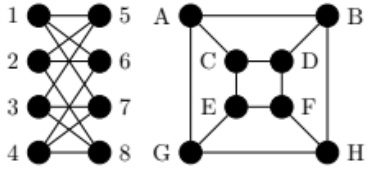</center>

The two graphs are isomorphic - they have the same structure, just with different labels on the nodes. You can match up the nodes between the graphs-- 1 goes to A, 2 goes to B, 3 goes to C, and so on. This one-to-one pairing of the nodes shows that the graphs are essentially identical, just with different names for the nodes.

#### Problem 3.2 (5 points)

Consider the 2 graphs in the following figure, where all nodes have a 1-dimensional initial feature vector $x = [1]$. We use a simplified version of Graph Neural Networks (GNNs), with no nonlinearity, no learned linear transformation, and sum aggregation.
Specifically, at every layer, the embedding of node $v$ is updated as the sum over the embeddings of its neighbors ($\mathcal{N}(v)$) and its current embedding $\bm{h}^{(t)}_v$ to get $\bm{h}^{(t+1)}_v$.
We run the GNN to compute node embeddings for the 2 red nodes respectively.
Note that the 2 red nodes have different 5-hop neighborhood structure (this is not the minimum number of hops for which the neighborhood structure of the 2 nodes differs).
How many layers of message passing are needed so that these 2 nodes can be distinguished (i.e., have different GNN embeddings)? Explain your answer in a few sentences.

<center>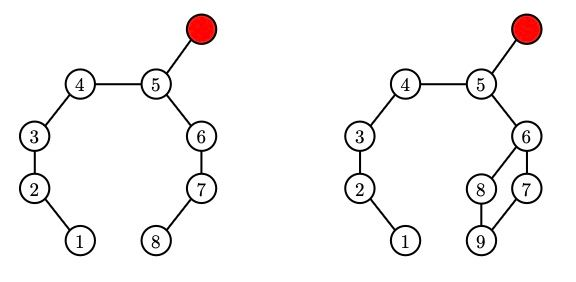</center>

It takes 5 layers of message passing for the GNN to distinguish the two red nodes. The 5-hop neighborhood structure around the two red nodes is different. This means that even with a simple GNN model using sum aggregation, the embeddings of these two nodes will eventually become different.

### Section 2: Dataset Access with PyTorch Geometric

PyTorch Geometric has two classes for storing and/or transforming graphs into tensor format. One is `torch_geometric.datasets`, which contains a variety of common graph datasets. Another is `torch_geometric.data`, which provides the data handling of graphs in PyTorch tensors.

In this section, we will learn how to use `torch_geometric.datasets` and `torch_geometric.data` together.

The `torch_geometric.datasets` class has many common graph datasets. Here we will explore its usage through one example dataset.

#### Problem 3.3 (5 points)
What is the number of classes and number of features in the ENZYMES dataset?

In [ ]:
from torch_geometric.datasets import TUDataset

root = 'datasets/enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset= TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

def get_num_classes(pyg_dataset):
    # TODO: Implement a function that takes a PyG dataset object
    # and returns the number of classes for that dataset.

    num_classes = 0

    ############# START YOUR CODE HERE ############
    ## (~1 line of code)
    num_classes = pyg_dataset.num_classes
    #############  END YOUR CODE HERE  ############

    return num_classes

def get_num_features(pyg_dataset):
    # TODO: Implement a function that takes a PyG dataset object
    # and returns the number of features for that dataset.

    num_features = 0

    ############# START YOUR CODE HERE ############
    ## (~1 line of code)
    num_features = pyg_dataset.num_node_features
    #############  END YOUR CODE HERE  ############

    return num_features

num_classes = get_num_classes(pyg_dataset)
num_features = get_num_features(pyg_dataset)
print(f"{name} dataset has {num_classes} classes")
print(f"{name} dataset has {num_features} features")

Processing...


ENZYMES(600)
ENZYMES dataset has 6 classes
ENZYMES dataset has 3 features


Done!


The ENZYMES dataset has 6 classes and 3 features.

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

#### Problem 3.4 (5 points)
What is the label of the graph with index 200 in the ENZYMES dataset?

In [ ]:
def get_graph_class(pyg_dataset, idx):
    # TODO: Implement a function that takes a PyG dataset object,
    # an index of a graph within the dataset, and returns the class/label
    # of the graph (as an integer).

    label = -1

    ############# START YOUR CODE HERE ############
    ## (~1 line of code)
    label = pyg_dataset[idx].y.item()
    #############  END YOUR CODE HERE  ############

    return label

# Here pyg_dataset is a dataset for graph classification
graph_0 = pyg_dataset[0]
print(graph_0)
idx = 200
label = get_graph_class(pyg_dataset, idx)
print(f'Graph with index {idx} has label {label}')

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Graph with index 200 has label 0


The label of the graph with index 200 in the ENZYMES dataset is 0.

#### Problem 3.5 (5 points)
How many edges does the graph with index 100 have?

In [ ]:
def get_graph_num_edges(pyg_dataset, idx):
    # TODO: Implement a function that takes a PyG dataset object,
    # the index of a graph in the dataset, and returns the number of
    # edges in the graph (as an integer). You should not count an edge
    # twice if the graph is undirected. For example, in an undirected
    # graph G, if two nodes v and u are connected by an edge, this edge
    # should only be counted once.

    num_edges = 0

    ############# START YOUR CODE HERE ############
    ## Note:
    ## 1. You cannot return the data.num_edges directly
    ## 2. We assume the graph is undirected
    ## 3. Look at the PyG dataset built in functions
    ## (~4 lines of code)
    data = pyg_dataset[idx]
    num_edges = data.edge_index.size(1) // 2 # Number of edges  is half length of edge_index
    #############  END YOUR CODE HERE  ############

    return num_edges

idx = 100
num_edges = get_graph_num_edges(pyg_dataset, idx)
print(f'Graph with index {idx} has {num_edges} edges')

Graph with index 100 has 88 edges


The graph with index 100 has 88 edges.

### Section 2: Node Property Prediction

In this section we will build our first graph neural network using PyTorch Geometric. Then we will apply it to the task of node property prediction (node classification).


Specifically, we will use GCN as the foundation for your graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer.

For evaluation, we will use the Open Graph Benchmark (OGB), which is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can then be evaluated by using the OGB Evaluator in a unified manner.

In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

# Load and process the dataset
dataset_name = 'ogbn-arxiv'
#dataset = PygNodePropPredDataset(
    #name=dataset_name, transform=T.ToSparseTensor())
dataset = PygNodePropPredDataset(name=dataset_name, transform=T.Compose([T.ToUndirected(), T.ToSparseTensor()]))
data = dataset[0]
#print(f"edge_index type: {type(data.edge_index)}")

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:01<00:00, 66.33it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 1793.97it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2770.35it/s]

Saving...



Done!
/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

#### Problem 3.6 (20 points)

Now we will implement our GCN model! Please follow the figure below to implement the `forward` function.

<center>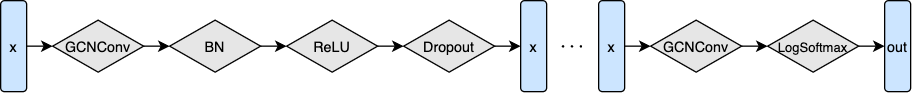</center>

In [ ]:
class GCN(torch.nn.Module):
    def __init__(
            self, input_dim, hidden_dim, output_dim, num_layers,
            dropout, return_embeds=False):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = None

        # A list of 1D batch normalization layers
        self.bns = None

        # The log softmax layer
        self.softmax = None

        ############# START YOUR CODE HERE ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        ## (~10 lines of code)
        # Initialize GCN layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))  # First layer

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))  # Hidden layers

        self.convs.append(GCNConv(hidden_dim, output_dim))  # Last layer

        # BatchNorm layers
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        # Log softmax layer
        self.softmax = torch.nn.LogSoftmax(dim=1)
        #############  END YOUR CODE HERE  ############

        # Probability of element getting zeroed
        self.dropout = dropout

        # Return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement a function that takes the feature tensor x and
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.

        out = None

        ############# START YOUR CODE HERE ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer
        ## (~7 lines of code)
        # Initialize output with the input feature tensor
        out = x

        # Apply layers
        for i in range(len(self.convs) - 1):
            out = self.convs[i](out, adj_t)       # Apply GCN layer
            out = self.bns[i](out)                # Apply BatchNorm
            out = F.relu(out)                     # Apply ReLU activation
            out = F.dropout(out, p=self.dropout, training=self.training)  # Apply Dropout

        # Final GCN layer with no BatchNorm, ReLU, and Dropout
        out = self.convs[-1](out, adj_t)

        if not self.return_embeds:
            out = self.softmax(out)
        #############  END YOUR CODE HERE  ############

        return out

In [ ]:
def train(model, data, train_idx, optimizer, loss_fn):
    # TODO: Implement a function that trains the model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    ############# START YOUR CODE HERE ############
    ## Note:
    ## 1. Zero grad the optimizer
    ## 2. Feed the data into the model
    ## 3. Slice the model output and label by train_idx
    ## 4. Feed the sliced output and label to loss_fn
    ## (~4 lines of code)
    optimizer.zero_grad()
    out = model(data.x, data.adj_t)

    # Step 3: Select only the training nodes by indexing with train_idx
    out = out[train_idx]
    label = data.y[train_idx].squeeze()

    # Step 4: Compute the loss
    loss = loss_fn(out, label)
    #############  END YOUR CODE HERE  ############

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator):
    # TODO: Implement a function that tests the model by
    # using the given split_idx and evaluator.
    model.eval()

    # The output of model on all data
    out = None

    ############# START YOUR CODE HERE ############
    ## (~1 line of code)
    ## Note: No index slicing here
    out = model(data.x, data.adj_t)  # Compute output on the entire dataset
    #############  END YOUR CODE HERE  ############

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [ ]:
# Please do not change the args
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}
model = GCN(
    data.num_features, args['hidden_dim'],
    dataset.num_classes, args['num_layers'],
    args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-arxiv')

What are your `best_model` validation and test accuracies? Run the cells below to see the results of your best of model.

In [ ]:
# Please do not change these args
import copy

# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args['epochs']):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}%, Test: {100 * test_acc:.2f}%')

best_result = test(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}%, Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 4.0554, Train: 24.97%, Valid: 28.57%, Test: 25.66%
Epoch: 02, Loss: 2.3473, Train: 26.44%, Valid: 25.62%, Test: 30.70%
Epoch: 03, Loss: 1.9587, Train: 31.50%, Valid: 30.27%, Test: 35.05%
Epoch: 04, Loss: 1.7884, Train: 41.14%, Valid: 40.99%, Test: 42.23%
Epoch: 05, Loss: 1.6629, Train: 43.70%, Valid: 43.99%, Test: 43.97%
Epoch: 06, Loss: 1.5915, Train: 43.69%, Valid: 40.83%, Test: 43.69%
Epoch: 07, Loss: 1.5150, Train: 44.72%, Valid: 39.16%, Test: 43.23%
Epoch: 08, Loss: 1.4501, Train: 45.25%, Valid: 38.40%, Test: 43.13%
Epoch: 09, Loss: 1.4087, Train: 45.95%, Valid: 38.71%, Test: 43.55%
Epoch: 10, Loss: 1.3740, Train: 46.95%, Valid: 40.32%, Test: 45.40%
Epoch: 11, Loss: 1.3421, Train: 47.88%, Valid: 43.02%, Test: 47.73%
Epoch: 12, Loss: 1.3143, Train: 49.21%, Valid: 45.20%, Test: 49.57%
Epoch: 13, Loss: 1.2904, Train: 50.97%, Valid: 47.59%, Test: 51.56%
Epoch: 14, Loss: 1.2693, Train: 53.43%, Valid: 51.03%, Test: 54.35%
Epoch: 15, Loss: 1.2554, Train: 55.64%, Valid: 5

The best model achieved a validation accuracy of 71.92% and a test accuracy of 71.37%.

### Section 3: Graph Property Prediction

In this section we will create a graph neural network for graph property prediction (graph classification).

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

# Load the dataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

split_idx = dataset.get_idx_split()

# Check task type
print('Task type: {}'.format(dataset.task_type))

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 66635.64it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:02<00:00, 17591.11it/s]


Saving...
Task type: binary classification


Done!
/usr/local/lib/python3.10/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

In [ ]:
# Load the dataset splits into corresponding dataloaders
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

# Please do not change the args
args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 30,
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Problem 3.7 (15 points)

Before diving into the actual model, we introduce the concept of [mini-batching with graphs](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches). In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings.

Now, we have all of the tools to implement a GCN Graph Prediction model. We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.

In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# START YOUR CODE HERE ############
        ## Note: Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        self.pool = global_mean_pool
        #############  END YOUR CODE HERE  ############

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
        self.gnn_node.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement a function that takes as input a
        # mini-batch of graphs (torch_geometric.data.Batch) and
        # returns the predicted graph property for each graph.
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch


        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        out = None

        ############# START YOUR CODE HERE ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property
        ## (~3 lines of code)
        # Node embeddings using GCN model
        node_embeddings = self.gnn_node(embed, edge_index)

        #Create graph-level embeddings
        graph_embeddings = self.pool(node_embeddings, batch)

        # Predict graphs' property
        out = self.linear(graph_embeddings)
        #############  END YOUR CODE HERE  ############

        return out

#### Problem 3.8 (10 points)

Implement the training and test function for your `GCN_Graph` model.

In [ ]:
def train(model, device, data_loader, optimizer, loss_fn):
    # TODO: Implement a function that trains your model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc='Iteration')):
        batch = batch.to(device)

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            ## ignore nan targets (unlabeled) when computing training loss.
            is_labeled = batch.y == batch.y

            ############# START YOUR CODE HERE ############
            ## Note:
            ## 1. Zero grad the optimizer
            ## 2. Feed the data into the model
            ## 3. Use `is_labeled` mask to filter output and labels
            ## 4. You may need to change the type of label to torch.float32
            ## 5. Feed the output and label to the loss_fn
            ## (~3 lines of code)
            # Zero grad the optimizer
            optimizer.zero_grad()

            # Feed the data into the model
            output = model(batch)

            # Use the `is_labeled` mask to filter output and labels
            filtered_output = output[is_labeled]
            filtered_labels = batch.y[is_labeled].to(torch.float32)  # changed labels to torch.float32

            # Feed the output and label to the loss_fn
            loss = loss_fn(filtered_output, filtered_labels)
            #############  END YOUR CODE HERE  ############

            loss.backward()
            optimizer.step()

    return loss.item()

In [ ]:
# The evaluation function
def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc='Iteration')):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    input_dict = {'y_true': y_true, 'y_pred': y_pred}
    return evaluator.eval(input_dict)

In [ ]:
model = GCN_Graph(
    args['hidden_dim'], dataset.num_tasks, args['num_layers'], args['dropout']).to(device)
evaluator = Evaluator(name='ogbg-molhiv')

# Please do not change these args
import copy

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args['epochs']):
    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, valid_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {100 * train_acc:.2f}%, Valid: {100 * valid_acc:.2f}%, Test: {100 * test_acc:.2f}%')

Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0346, Train: 70.50%, Valid: 71.54%, Test: 71.51%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.6271, Train: 74.66%, Valid: 75.44%, Test: 70.54%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 03, Loss: 0.0218, Train: 75.79%, Valid: 78.26%, Test: 70.46%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 04, Loss: 0.5299, Train: 76.73%, Valid: 76.72%, Test: 70.08%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 05, Loss: 0.0349, Train: 75.77%, Valid: 77.23%, Test: 71.57%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 06, Loss: 0.0521, Train: 78.20%, Valid: 76.20%, Test: 71.28%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 07, Loss: 0.0257, Train: 78.84%, Valid: 75.29%, Test: 68.26%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 08, Loss: 0.0265, Train: 78.87%, Valid: 76.94%, Test: 69.37%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.8328, Train: 77.97%, Valid: 74.85%, Test: 72.79%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.0587, Train: 80.09%, Valid: 76.74%, Test: 70.66%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.0315, Train: 80.41%, Valid: 77.53%, Test: 72.47%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.0560, Train: 80.94%, Valid: 77.93%, Test: 73.16%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.0246, Train: 81.40%, Valid: 78.47%, Test: 73.63%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.0138, Train: 81.45%, Valid: 76.70%, Test: 73.07%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.0187, Train: 80.93%, Valid: 76.24%, Test: 72.10%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.0384, Train: 81.77%, Valid: 77.10%, Test: 71.80%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.1023, Train: 82.17%, Valid: 78.07%, Test: 73.70%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.0229, Train: 81.74%, Valid: 77.45%, Test: 74.27%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.0313, Train: 82.18%, Valid: 77.48%, Test: 73.67%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.0157, Train: 82.19%, Valid: 78.45%, Test: 72.72%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.0516, Train: 82.76%, Valid: 77.38%, Test: 74.40%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.5431, Train: 82.70%, Valid: 76.20%, Test: 74.29%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.4968, Train: 82.83%, Valid: 74.60%, Test: 72.59%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.0616, Train: 83.75%, Valid: 77.46%, Test: 74.56%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.0298, Train: 82.45%, Valid: 78.39%, Test: 74.52%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.0220, Train: 81.93%, Valid: 76.09%, Test: 73.87%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.0725, Train: 84.00%, Valid: 77.59%, Test: 75.17%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.0660, Train: 84.55%, Valid: 78.37%, Test: 73.78%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.0620, Train: 83.57%, Valid: 76.99%, Test: 75.68%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.0144, Train: 83.58%, Valid: 79.33%, Test: 73.78%


What are your `best_model` validation and test ROC-AUC scores? Run the cell below to see the results of your best of model.

In [ ]:
train_auroc = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_auroc = eval(best_model, device, valid_loader, evaluator)[dataset.eval_metric]
test_auroc  = eval(best_model, device, test_loader, evaluator)[dataset.eval_metric]

print(f'Best model: Train: {100 * train_auroc:.2f}%, Valid: {100 * valid_auroc:.2f}%, Test: {100 * test_auroc:.2f}%')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Best model: Train: 83.58%, Valid: 79.33%, Test: 73.78%


The best model achieved a validation ROC-AUC score of 79.33% and a test ROC-AUC score of 73.78%.

## Part 4: The Transformer Model (80 points)

In this assignment, you will build a Transformer model from scratch using PyTorch. This exercise aims to deepen your understanding of the Transformer architecture, as introduced by Vaswani et al. in the landmark paper [*Attention is All You Need*](https://arxiv.org/abs/1706.03762). By implementing the various components of the Transformer, you will gain hands-on experience with key concepts such as self-attention mechanisms, positional encoding, and the overall architecture of the Transformer model.

### Key Components of the Transformer

<center></center>

1. **Encoder and Decoder**: The Transformer model consists of an encoder to process the input text and a decoder to generate the output text. Both the encoder and decoder are composed of multiple layers that contain self-attention and feed-forward neural network components.
2. **Multi-Head Attention**: This component allows the model to jointly attend to information from different representation subspaces at different positions. Implementing multi-head attention is a critical part of this assignment.
3. **Positional Encoding**: Since the model contains no recurrence or convolution, positional encodings are added to give the model some information about the relative or absolute position of the tokens in the sequence.
4. **Feed-Forward Networks**: Each layer of the encoder and decoder contains a feed-forward neural network which applies two linear transformations and a ReLU activation in between.

In the following sections, you will implement these components step by step.

### Problem 4.1: Multi-Head Attention (20 points)

The attention mechanism computes the dot product between the query and key vectors, scaled by the square root of the dimension of the key vectors. The attention weights are then used to compute a weighted sum of the value vectors.
Please implement the `scaled_dot_product_attention` function at first, which will used as a building block for the multi-head attention mechanism. This function computes the attention weights and the weighted sum of the value vectors, given the projected query, key, and value vectors.

In [3]:
import math
import torch
from torch import nn
from torch.nn import functional as F

def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute the scaled dot product attention.

    Parameters:
    - query (torch.Tensor): Queries tensor with shape (batch_size, num_heads, seq_len_q, depth).
    - key (torch.Tensor): Keys tensor with shape (batch_size, num_heads, seq_len_k, depth).
    - value (torch.Tensor): Values tensor with shape (batch_size, num_heads, seq_len_v, depth).
    - mask (torch.Tensor, optional): Mask tensor to filter out certain positions before
      applying softmax. The mask's shape is broadcastable to (batch_size, num_heads, seq_len_q, seq_len_k).
      The mask will contain either 0 values to indicate that the corresponding token in the input sequence
      should be considered in the computations or a 1 to indicate otherwise.

    Returns:
    - torch.Tensor: The output after applying attention to the value vector. Shape is (batch_size, num_heads, seq_len_q, depth).
    - torch.Tensor: The attention weights. Shape is (batch_size, num_heads, seq_len_q, seq_len_k).
    """

    # TODO: Compute the matrix multiplication between the query and key tensors
    # Hint: The resulting tensor has shape (batch_size, num_heads, seq_len_q, seq_len_k)
    matmul_qk = torch.matmul(query, key.transpose(-2, -1)) # Dot product of query and key
    assert matmul_qk.size() == (query.size(0), query.size(1), query.size(2), key.size(2))

    d_k = query.size(-1)
    # TODO: Scale the attention weights by the dimension of the key
    scaled_attention_logits = matmul_qk / math.sqrt(d_k) # Scaling by square root of key dimension

    # TODO: Apply the mask to the scaled tensor
    # Hint: You can use the `masked_fill` method of the tensor and mask out
    #   certain positions to a large negative number (e.g., -1e9)
    #   such that the attention weights will be zero after applying softmax
    if mask is not None:
      scaled_attention_logits = scaled_attention_logits.masked_fill(mask == 0, -1e9) # Assign a large negative number to masked positions
      pass

    # TODO: Apply the softmax function to obtain the attention weights
    attention_weights = F.softmax(scaled_attention_logits, dim=-1) # convert to attention weights

    # TODO: Apply the attention weights to the value tensor
    output = torch.matmul(attention_weights, value) # Outputs final weighted output (focuses on important tokens)
    return output, attention_weights

You can verify your implementation by running the test cases provided.

In [4]:
batch_size = 4
num_heads = 8
seq_len_q = 10
seq_len_k = 10
seq_len_v = 10
depth = 128

query = torch.rand(batch_size, num_heads, seq_len_q, depth)
key = torch.rand(batch_size, num_heads, seq_len_k, depth)
value = torch.rand(batch_size, num_heads, seq_len_v, depth)

output, attention_weights = scaled_dot_product_attention(query, key, value)

assert output.shape == (batch_size, num_heads, seq_len_q, depth)
assert attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)

from torch.nn.functional import scaled_dot_product_attention as torch_scaled_dot_product_attention
from torch.testing import assert_close

torch_output = torch_scaled_dot_product_attention(query, key, value)
assert_close(output, torch_output, rtol=1e-6, atol=1e-6)

In Transformers, there are multiple "attention heads", each of which captures a different aspect of the input.
At first, the query and key vectors are passed through a linear layer to project them to a higher-dimensional space. Then, the scaled dot-product attention is applied to each of these projected versions of the query and key vectors. The output of the linear layer is then reshaped to split the attention heads. The attention weights are computed for each head, and the weighted sum is then concatenated and passed through another linear layer to produce the final output.
Please implement the `MultiHeadAttention` class, which contains the logic for the multi-head attention mechanism.

In [5]:
class MultiHeadAttention(torch.nn.Module):
    """
    Multi-Head Attention module takes in queries, keys, and values, and
    performs scaled dot-product attention on them. This implementation also
    supports masking irrelevant positions.

    Parameters:
    - d_model (int): The dimension of the input embedding vectors.
    - num_heads (int): The number of attention heads. d_model must be divisible by num_heads.

    The architecture splits the input embedding vector into multiple heads because
    it allows the model to jointly attend to information from different representation
    subspaces at different positions. After the attention is applied, the heads are
    concatenated and linearly transformed back to the original d_model dimension.
    """

    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.wq = torch.nn.Linear(d_model, d_model)
        self.wk = torch.nn.Linear(d_model, d_model)
        self.wv = torch.nn.Linear(d_model, d_model)
        self.dense = torch.nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension of the input into (num_heads, depth).
        Transpose the result such that the shape becomes (batch_size, num_heads, seq_len, depth)
        to prepare for parallel computation of attention heads.

        Parameters:
        - x (torch.Tensor): The input tensor.
        - batch_size (int): Batch size for reshaping.

        Returns:
        - torch.Tensor: The reshaped tensor with dimensions (batch_size, num_heads, seq_len, depth).
        """

        x = x.view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        return x

    def forward(self, q, k, v, mask=None):
        """
        The forward pass for the Multi-Head Attention layer.

        Parameters:
        - q, k, v (torch.Tensor): Queries, keys, and values respectively. These tensors have shapes
          (batch_size, seq_len, d_model).
        - mask (torch.Tensor, optional): The mask tensor can be used to mask out (ignore) certain positions
          during the attention mechanism. This is useful for masking padded positions in the input
          sequences or to enforce causality in decoder self-attention. The shape of the mask tensor
          should be (batch_size, 1, 1, seq_len) for padding mask, or (batch_size, 1, seq_len, seq_len)
          for look-ahead mask.

        Returns:
        - torch.Tensor: The output after applying multi-head attention. Shape is (batch_size, seq_len, d_model).
        - torch.Tensor: The attention weights. Shape is (batch_size, num_heads, seq_len, seq_len).
        """

        batch_size = q.size(0)

        # TODO: Apply linear transformations to the queries, keys, and values
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # TODO: Split the queries, keys, and values into (batch_size, num_heads, seq_len, depth) using the split_heads method
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        output, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # TODO: Concatenate multiple attention heads
        # Hint: The shape of the output should be (batch_size, seq_len, d_model)
        # Calculates attention weights for each head
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, -1, self.d_model)

        output = self.dense(output)
        return output, attention_weights

### Problem 4.2: Positional Encoding (20 points)

Positional Encoding is a method used to inject some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. There are many choices of positional encodings, learned and fixed. In this assignment, you will implement the fixed positional encoding as described in the following equations:

$$
\begin{align}
    PE_{(pos, 2i)} & = \sin(pos/10000^{2i/d_{model}}), \\
    PE_{(pos, 2i+1)} & = \cos(pos/10000^{2i/d_{model}}),
\end{align}
$$
where $pos$ is the word position and $i$ is the embedding dimension.

In [6]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        # TODO: Use the formula given in the original paper to compute the positional encodings
        # Hint: Remember to add one more dimension to the encoding tensor so that it can be broadcasted
        #   to (batch_size, max_len, d_model) when added to the input tensor
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # Calculate divisor
        pe[:, 0::2] = torch.sin(position * div_term) # For even index, we apply sin
        pe[:, 1::2] = torch.cos(position * div_term) # Odd index -> cosine
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # TODO: Apply the positional encoding to the input tensor
        x = x + self.pe[:, :x.size(1), :]
        return x

### Problem 4.3: Encoder and Decoder (20 points)

This section would involve more detailed implementation, including the sub-layer connections, normalization, and how they are combined to form the complete encoder and decoder architecture. Specifically, you will implement the following components:
- `EncoderLayer`, which contains a multi-head attention layer and a feed-forward neural network, each followed by a residual connection and layer normalization.
- `DecoderLayer`, which contains three sub-layers: masked multi-head attention, multi-head attention, and a feed-forward neural network, each followed by a residual connection and layer normalization.

In [7]:
def pointwise_feedforward_network(d_model, dff):
    return nn.Sequential(
        nn.Linear(d_model, dff),
        nn.ReLU(),
        nn.Linear(dff, d_model)
    )

In [8]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        """
        Initialize an EncoderLayer.

        Parameters:
        - d_model (int): The dimensionality of the model.
        - num_heads (int): The number of attention heads.
        - dff (int): The dimensionality of the feed-forward network model.
        - dropout_rate (float): The dropout rate.
        """
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = pointwise_feedforward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dropout2 = torch.nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        """
        The forward pass for the EncoderLayer.

        Parameters:
        - x (Tensor): Input tensor to the encoder layer.
        - mask (Tensor, optional): The mask for padding tokens to ignore during self-attention.

        Returns:
        - Tensor: The output of the encoder layer.
        """
        # TODO: Step 1: Apply multi-head attention (with padding mask) and add & norm
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # Add layer normalization

        # TODO: Step 2: Apply the feed-forward network and add & norm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # Add layer normalization

        return out2

In [9]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        """
        Initialize a DecoderLayer.

        Parameters:
        - d_model (int): The dimensionality of the model, i.e., the size of the input and output embeddings.
        - num_heads (int): The number of attention heads.
        - dff (int): The dimensionality of the feed-forward network model.
        - dropout_rate (float): The dropout rate.
        """
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)  # Self-attention
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # Cross-attention

        self.ffn = pointwise_feedforward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.dropout3 = torch.nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        """
        The forward pass for the DecoderLayer.

        Parameters:
        - x (Tensor): Input tensor for decoder layer.
        - enc_output (Tensor): Output from the encoder (serves as Key and Value for cross attention).
        - look_ahead_mask (Tensor, optional): The mask for future tokens in a sequence within the self-attention mechanism.
        - padding_mask (Tensor, optional): The mask for padding tokens within the encoder output.
        """
        # TODO: Step 1: Self attention with look ahead mask and padding mask
        attn1, _ = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)  # Add layer normalization

        # TODO: Step 2: Cross attention where query comes from previous layer, and key, value come from encoder output
        attn2, _ = self.mha2(out1, enc_output, enc_output, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)  # Add layer normalization

        # TODO: Step 3: Apply the feed forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(out2 + ffn_output)  # Add layer normalization

        return out3

In [10]:
class Encoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_position_encoding, dropout_rate):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_position_encoding)

        self.enc_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])

        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        # Adding embedding and position encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [11]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_position_encoding, dropout_rate):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_position_encoding)

        self.dec_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

        return x  # (batch_size, target_seq_len, d_model)

### Problem 4.4: Masking (20 points)

An important step in training the Transformer model is to mask the attention weights for the future tokens in the sequence.
Let's consider a simplified scenario where we have an input sequence in English "Hello World" and a hypothetical target sequence in German "Hallo Welt" during training. We will tokenize these sequences into numerical tokens (assume a simple tokenization for illustration) and show how the `generate_mask` function generates the padding and look-ahead masks for these sequences.

First, let's assign numerical tokens to our sequences. In a real scenario, these would come from a tokenizer's vocabulary:
* English (Source) Tokens: "Hello World" → [1, 2]
* German (Target) Tokens: "Hallo Welt" → [1, 2]

Assume padding token ID is 0, and both sequences are already padded to a maximum length of 4 for this example:
* Padded English Sequence: [1, 2, 0, 0]
* Padded German Sequence (with EOS token for simplicity): [1, 2, 3, 0] where 3 is the EOS token.

The source mask allows the model to ignore the padding tokens in the source sequence. It would look something like this for the example:
```Python
src_mask = [[[1, 1, 0, 0]]]  # Shape: (batch_size, 1, 1, src_seq_len)
```
This indicates that the first two tokens are valid while the last two are padding tokens that should be ignored.

The target mask is a combination of padding mask and look-ahead mask to ensure that for predicting each token, the model can only attend to previous tokens and ignores future tokens as well as padding. For our target sequence, considering both padding and look-ahead constraints, the mask might look like:
```Python
tgt_mask =
[[[[1, 0, 0, 0],
   [1, 1, 0, 0],
   [1, 1, 1, 0],
   [1, 1, 1, 0]]]]  # Shape: (batch_size, 1, tgt_seq_len, tgt_seq_len)
```
Here, the first row allows attention to the first token, the second row to the first and second tokens, and so on. The last token does not attend to future tokens (it can't see them), and since it's an EOS token, it correctly doesn't need to see beyond its position, but the model design might mask it differently based on implementation specifics.

Please refer to the comments in the code cells for more detailed instructions on how to implement these two masks.

In [25]:
def generate_mask(src, tgt):
    """
    Generates padding and look-ahead masks for source and target sequences.
    Suppose that the padding token is 0.

    Parameters:
    - src (Tensor): The source sequence tensor with shape (batch_size, src_seq_len).
    - tgt (Tensor): The target sequence tensor with shape (batch_size, tgt_seq_len).

    Returns:
    - Tensor: The padding mask for the source sequence.
    - Tensor: The combined padding and look-ahead mask for the target sequence.
    """

    # TODO: Create a mask for the source sequence padding tokens.
    # This mask is used to ignore the padding tokens in the source sequence during the attention calculations.
    # The mask has dimensions (batch_size, 1, 1, src_seq_len) after unsqueezing, suitable for broadcasting
    # with the attention scores tensor.
    src_mask = (src == 0).unsqueeze(1).unsqueeze(2)

    # TODO: Create a mask for the target sequence padding tokens.
    # Similar to src_mask, but for the target sequence, preparing it for broadcasting.
    # The initial dimensions after unsqueezing are (batch_size, 1, tgt_seq_len, 1), which is suitable for
    # look-ahead masking when combined with the nopeak_mask.
    tgt_mask = (tgt == 0).unsqueeze(1).unsqueeze(3)  # Padding and look-ahead masking

    # TODO: Generate a no-peek (look-ahead) mask to prevent positions from attending to subsequent positions.
    # This is crucial for the target sequence during training, ensuring predictions for position i
    # can only depend on the known outputs at positions less than i.
    seq_len = tgt.size(1)
    nopeak_mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0).to(tgt.device)
    nopeak_mask = nopeak_mask == 0

    # TODO: Combine the padding mask and the look-ahead mask for the target sequence.
    # This ensures that the model does not attend to padding tokens and future tokens.
    tgt_mask = tgt_mask | nopeak_mask  # Combination of padding and look-ahead masks

    return src_mask, tgt_mask

Putting all these components together, we get our complete Transformer model.

In [26]:
class Transformer(torch.nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_encoder_layers, d_model, num_heads, dff, input_vocab_size, pe_input, dropout_rate)
        self.decoder = Decoder(num_decoder_layers, d_model, num_heads, dff, target_vocab_size, pe_target, dropout_rate)
        self.final_layer = torch.nn.Linear(d_model, target_vocab_size)

    def forward(self, inp, tar):
        # Generate masks
        src_mask, tgt_mask = generate_mask(inp, tar)

        # Pass the input through the encoder, which uses src_mask
        enc_output = self.encoder(inp, src_mask)  # (batch_size, inp_seq_len, d_model)

        # Pass the encoder output and target through the decoder, which uses tgt_mask and src_mask
        dec_output = self.decoder(tar, enc_output, tgt_mask, src_mask)  # (batch_size, tar_seq_len, d_model)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

Before you move on to experiment on a real dataset, you may verify that your Transformer model is working correctly with a synthetically generated dataset.

In [27]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 2
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(
    num_layers, num_layers, d_model, num_heads, d_ff,
    src_vocab_size, tgt_vocab_size,
    pe_input=max_seq_length, pe_target=max_seq_length, dropout_rate=dropout).to(device)

src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)

output = transformer(src_data, tgt_data)

### Putting It All Together: Transformer Model

In this section, you will train your Transformer model on a translation task using the WMT German-English dataset.
After training, you will evaluate the model on a test set.
Before you start training, make sure that you have installed the necessary packages and have access to a GPU for faster training.

In [28]:
%pip install datasets transformers sacrebleu evaluate

In [29]:
from datasets import load_dataset

dataset = load_dataset('wmt14', 'de-en', split={'train': 'train[:1%]', 'test': 'test', 'validation': 'validation'})
train_data = dataset['test']
valid_data = dataset['validation']

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

def tokenize_data(examples, max_length=128):
    inputs = [ex['de'] for ex in examples['translation']]
    targets = [ex['en'] for ex in examples['translation']]
    model_inputs = tokenizer(inputs, max_length=max_length, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=max_length, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_train_data = train_data.map(tokenize_data, batched=True).with_format(type='torch', columns=['input_ids', 'labels'])
tokenized_valid_data = valid_data.map(tokenize_data, batched=True).with_format(type='torch', columns=['input_ids', 'labels'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [31]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(tokenized_valid_data, batch_size=64)

To determine the appropriate length of the maximum sequence, you might want to inspect the length distribution of the training data. You can then set the maximum sequence length to a value that covers most of the training data.

In [32]:
import numpy as np

lengths = [len(tokenizer.tokenize(example['en'])) for example in train_data['translation']]

lengths = np.array(lengths)
mean_length = np.mean(lengths)
max_length = np.max(lengths)
median_length = np.median(lengths)
percentile_90 = np.percentile(lengths, 90)

print(f"Mean length: {mean_length}")
print(f"Max length: {max_length}")
print(f"Median length: {median_length}")
print(f"90th percentile length: {percentile_90}")

Mean length: 24.776223776223777
Max length: 116
Median length: 22.0
90th percentile length: 42.0


In [33]:
import torch.optim as optim

num_encoder_layers = 6
num_decoder_layers = 6
max_seq_length = 512
d_model = 512
num_heads = 8
dff = 2048
dropout_rate = 0.1
input_vocab_size = tokenizer.vocab_size
target_vocab_size = tokenizer.vocab_size

model = Transformer(
    num_layers, num_layers, d_model, num_heads, d_ff,
    input_vocab_size, target_vocab_size,
    pe_input=max_seq_length, pe_target=max_seq_length, dropout_rate=dropout).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In sequence-to-sequence (seq2seq) models, such as Transformers, the label shifting technique, often referred to as "teacher forcing" when used during training, plays a crucial role in the learning process. This technique involves shifting the labels by one position so that the model predicts the next token in the sequence given all the previous tokens up to that point.

Suppose we have the following English sentence (source) and its French translation (target):
- **English (Source)**: "Hello, world"
- **French (Target)**: "Bonjour, le monde"

Input to the Model (Encoder Input): The input sequence to the encoder would be the English sentence, tokenized and possibly including special tokens like start-of-sequence (SOS) or end-of-sequence (EOS) tokens, depending on the model architecture:
- **Encoder Input**: `[SOS] Hello, world [EOS]`

Target Sequence for Teacher Forcing (Decoder Input): The target sequence for teacher forcing (used as input to the decoder) is shifted by one token to the right, to teach the model to predict the next token in the sequence. It includes an SOS token at the beginning to indicate the start of the sequence but omits the EOS token or includes it only as part of the ground truth for the final step, ensuring that for each input token, the model learns to predict the subsequent token:
- **Decoder Input**: `[SOS] Bonjour, le monde`

The ground truth data against which the model's predictions are compared is the target sequence shifted one position to the left, excluding the SOS token and including the EOS token. This ensures that for every step of the sequence, the model is trained to predict the next token:
- **Ground Truth Data**: `Bonjour, le monde [EOS]`

To visualize the shifting, consider how each token in the decoder input is used to predict the corresponding token in the ground truth data:
- Decoder Input: `[SOS]` → Predicts → `Bonjour`
- Decoder Input: `Bonjour` → Predicts → `,`
- Decoder Input: `,` → Predicts → `le`
- Decoder Input: `le` → Predicts → `monde`
- Decoder Input: `monde` → Predicts → `[EOS]`

In [34]:
model.train()
for epoch in range(50):
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, labels[:, :-1])
        output_dim = output.shape[-1]  # Vocabulary size
        # Reshape output to (batch_size * seq_len, output_dim) for calculating loss
        output = output.reshape(-1, output_dim)
        labels = labels[:, 1:].reshape(-1)  # Flatten labels to align with output for CrossEntropyLoss

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 6.198858737945557
Epoch 2, Loss: 5.315392971038818
Epoch 3, Loss: 4.6688971519470215
Epoch 4, Loss: 3.4759278297424316
Epoch 5, Loss: 3.083738327026367
Epoch 6, Loss: 2.0064971446990967
Epoch 7, Loss: 1.7473253011703491
Epoch 8, Loss: 1.2317571640014648
Epoch 9, Loss: 1.0001083612442017
Epoch 10, Loss: 0.5765084028244019
Epoch 11, Loss: 0.4035431146621704
Epoch 12, Loss: 0.37806516885757446
Epoch 13, Loss: 0.29122501611709595
Epoch 14, Loss: 0.1965586394071579
Epoch 15, Loss: 0.16739699244499207
Epoch 16, Loss: 0.12306201457977295
Epoch 17, Loss: 0.11130615323781967
Epoch 18, Loss: 0.11884171515703201
Epoch 19, Loss: 0.11785968393087387
Epoch 20, Loss: 0.10509306192398071
Epoch 21, Loss: 0.05745241791009903
Epoch 22, Loss: 0.08181615173816681
Epoch 23, Loss: 0.06982476264238358
Epoch 24, Loss: 0.0500938817858696
Epoch 25, Loss: 0.09563293308019638
Epoch 26, Loss: 0.07478752732276917
Epoch 27, Loss: 0.08753421157598495
Epoch 28, Loss: 0.07000469416379929
Epoch 29, Loss: 0

Hugging Face provides various metrics through its datasets library. For translation tasks, BLEU is a common metric used to evaluate the quality of the model's translations. You can use the `datasets` library to load the WMT dataset and evaluate your model using BLEU score.

In [35]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

model.eval()
predictions = []
references = []

for batch in valid_loader:
    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)  # Ground truth labels

    with torch.no_grad():
        outputs = model(input_ids, labels)

    # Convert model outputs to predicted tokens
    predicted_tokens = torch.argmax(outputs, dim=-1)

    # Convert tokens to texts
    predicted_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predicted_tokens]
    reference_texts = [[tokenizer.decode(ids, skip_special_tokens=True)] for ids in labels]

    predictions.extend(predicted_texts)
    references.extend(reference_texts)

# Compute BLEU score
results = bleu_metric.compute(predictions=predictions, references=references)
print(f"BLEU score: {results['score']}")

BLEU score: 17.3211569635641


In [36]:
random_idx = np.random.randint(0, len(predictions))
print(f"Reference: {references[random_idx][0]}")
print(f"Predicted: {predictions[random_idx]}")

Reference: The Federal Security Service now spreads a big network of fake sites and there are tons of potential buyers of military weapons.
Predicted: The Federal Employment Agency and there a sign there of there and and there are inter of Germany of of military chemical. is


You might notice that there are lot of repeated words in the decoder's output.
This is a common issue known as "repetition problem" or "degeneration problem". This usually occurs during the generation phase, where the model falls into a loop, outputting the same word or phrase repeatedly. This is mostly due to the inadequate training of the model. There are several techniques to mitigate this issue, such as using beam search, nucleus sampling, or top-k sampling during the generation phase.